# Figure 5

In [1]:
from scipy import stats
import sys, data, ols
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import xarray as xr, pandas as pd

In [2]:
def anomaly(datax):
	"""input data is time period, time step w/in that period, latitude
	anomaly is relative to each time step w/in that period"""

	indx=np.arange(np.shape(datax)[1]) % 12

	for num in range(12):
		datax[:,num == indx,]=datax[:,num == indx,] - \
			np.ma.average(datax[:,num == indx,],axis=1)[:,np.newaxis,]	
	
	return datax

In [3]:
def colorplotLeftOLD(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['top','right']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # set axis positions
#     ax.yaxis.set_label_position(pspines[0]) 
#     ax.xaxis.set_label_position(pspines[1]) 
    
    for spx in ['bottom','left']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)

In [4]:
def colorplotLeft(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['bottom','right']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')
    
    # set axis positions
#     ax.yaxis.set_label_position(pspines[0]) 
    ax.xaxis.set_label_position('top') 
    
    for spx in ['top','left']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)

In [5]:
def detrend(datax):
    fitx=stats.linregress(np.arange(len(datax)),datax)
    datax = datax - np.arange(len(datax))*fitx.slope
    datax=data.anomaly(datax)
    return datax    

## load data

In [6]:
mod3=xr.open_dataset('historical/zonal/zonalEnsemble.nc')
forcing=xr.open_dataset('historical/zonal/forcing_zonal.nc')

In [7]:
mod3['time']=pd.to_datetime(mod3.time, format='%Y%m%d.%f')
mod3=mod3.groupby('time.year').mean(dim='time') # annual average

# display mod3 variable
mod3

<xarray.Dataset>
Dimensions:  (lat: 96, lev: 100, lon: 1, sfc: 100, year: 156)
Coordinates:
  * lon      (lon) float64 0.0
  * lat      (lat) float64 88.57 86.72 84.86 83.0 81.13 79.27 77.41 75.54 ...
  * sfc      (sfc) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  * lev      (lev) float64 5e+04 5e+04 5e+04 5e+04 5e+04 5e+04 5e+04 5e+04 ...
  * year     (year) int64 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 ...
Data variables:
    flux     (year, sfc, lat, lon) float32 -125.333496 -125.69625 -125.65411 ...
    temp2    (year, sfc, lat, lon) float32 256.39337 256.59824 256.68945 ...
    t        (year, lev, lat, lon) float32 237.72585 237.77869 237.9189 ...

In [8]:
# calculate net flux including forcing
forcing['flux']=forcing.srad0+forcing.trad0
forcex=np.array(forcing.flux[:156,]).reshape(156,1,96,1)
flux=np.array(mod3.flux)-forcex

global average calculation

In [9]:
def area_avg(d1c):
    """d1 is a numpy array, uses lat from mod3 xarray
    returns average of field in 3 different equal area regions
    SH, equatorial, NH"""
    
    def avg2(d2):
        """convert d2 from numpy array into data.Data3 and then average
        over the requested latitude ranges"""
        x1=data.Data3d(d2,[180.],np.copy(mod3.lat),range(100),range(156))
        return x1.global_average()

    # average into 3 bins of equal area, split around 19.4 N and S
    d1=np.copy(d1c)
    out1=avg2(d1)
    
    out1=np.array(out1).squeeze()

    return out1

fx=area_avg(flux)
ts1=area_avg(np.array(mod3.temp2))
ta1=area_avg(np.array(mod3.t))

NameError: name 'data' is not defined

In [ ]:
dflux1=np.average((fx[-10:,]-fx[:10,]).squeeze(),axis=0)
dts1=np.average((ts1[-10:,]-ts1[:10,]).squeeze(),axis=0)
dta1=np.average((ta1[-10:,]-ta1[:10,]).squeeze(),axis=0)
lambda1=dflux1/dts1;theta1=dflux1/dta1

calculate regional feedbacks

In [ ]:
def area_avg(d1c):
    """d1 is a numpy array, uses lat from mod3 xarray
    returns average of field in 3 different equal area regions
    SH, equatorial, NH"""
    
    def avg2(d2,lat1,lat2):
        """convert d2 from numpy array into data.Data3 and then average
        over the requested latitude ranges"""
        x1=data.Data3d(d2,[180.],mod3.lat,range(100),range(156))
        return x1.global_average((lat1,lat2))

    # average into 3 bins of equal area, split around 19.4 N and S
    d1=np.copy(d1c)
    out1=[avg2(d1,-90,-19.4)]
    out1.append(avg2(d1,-19.4,19.4))
    out1.append(avg2(d1,19.4,90))
#     out1=[avg2(d1,-90,-30)]
#     out1.append(avg2(d1,-30,30))
#     out1.append(avg2(d1,30,90))
    
    out1=np.array(out1).squeeze()

    return out1

fx=area_avg(flux)
ts1=area_avg(np.array(mod3.temp2))
ta1=area_avg(np.array(mod3.t))

In [ ]:
# estimate change from first decade to last
dflux=np.average((fx[:,-10:,]-fx[:,:10,]).squeeze(),axis=1)
dts=np.average((ts1[:,-10:,]-ts1[:,:10,]).squeeze(),axis=1)
dta=np.average((ta1[:,-10:,]-ta1[:,:10,]).squeeze(),axis=1)
ratioTs=dflux/dts;ratioTa=dflux/dta

In [ ]:
figure(figsize=(7,5))
yerr1=np.average(ratioTs,axis=1)-np.percentile(ratioTs,5,axis=1)
yerr2=np.percentile(ratioTs,95,axis=1)-np.average(ratioTs,axis=1)
errorbar(np.arange(3)+0.07,np.average(ratioTs,axis=1),yerr=[yerr1,yerr2],color='k',fmt='o',\
         markersize=12,label='$\lambda_r$')

yerr1=np.average(ratioTa,axis=1)-np.percentile(ratioTa,5,axis=1)
yerr2=np.percentile(ratioTa,95,axis=1)-np.average(ratioTa,axis=1)
errorbar(np.arange(3)-0.07,np.average(ratioTa,axis=1),yerr=[yerr1,yerr2],color='0.7',fmt='^',\
         markersize=12,label='$\Theta_r$')

xlabel('latitude',fontsize=16);ylabel('$\lambda_r$ or $\Theta_r$ ($W/m^2/K$)',fontsize=14)
xticks([0,1,2],'SH,EQ,NH'.split(','))
xlim(-0.5,2.5)
ylim(-3,0)
legend(loc=4,fontsize=14)
colorplotLeft(gca())

### plot individual high and low lambda models
# ind=np.where(lambda1 < np.percentile(lambda1,5))[0]
# for ii in range(3):
#     plot(np.zeros(len(ind))+ii+0.15,ratioTs[ii,ind],'k+')
# ind=np.where(lambda1 > np.percentile(lambda1,95))[0]
# for ii in range(3):
#     plot(np.zeros(len(ind))+ii+0.15,ratioTs[ii,ind],'r+')

# savefig('fig5.eps')
# savefig('fig5')

In [ ]:
figure(figsize=(7,5))
yerr1=np.average(ratioTs,axis=1)-np.percentile(ratioTs,5,axis=1)
yerr2=np.percentile(ratioTs,95,axis=1)-np.average(ratioTs,axis=1)
errorbar(np.arange(3)+0.07,np.average(ratioTs,axis=1),yerr=[yerr1,yerr2],color='k',fmt='o',\
         markersize=12,label='$\lambda$')

yerr1=np.average(ratioTa,axis=1)-np.percentile(ratioTa,5,axis=1)
yerr2=np.percentile(ratioTa,95,axis=1)-np.average(ratioTa,axis=1)
errorbar(np.arange(3)-0.07,np.average(ratioTa,axis=1),yerr=[yerr1,yerr2],color='0.7',fmt='^',\
         markersize=12,label='$\Theta$')

xlabel('latitude',fontsize=16);ylabel('$\lambda_r$ or $\Theta_r$ ($W/m^2/K$)',fontsize=18)
xticks([0,1,2],'SH,EQ,NH'.split(','))
xlim(-0.5,2.5)
ylim(-3,0)
legend(loc=4,fontsize=14)
colorplotLeft(gca())

if False: # print values from individual extreme ensemble members
    ind=np.where(lambda1 < np.percentile(lambda1,5))[0]
    for ii in range(3):
        plot(np.zeros(len(ind))+ii+0.15,ratioTs[ii,ind],'k+')
    ind=np.where(lambda1 > np.percentile(lambda1,95))[0]
    for ii in range(3):
        plot(np.zeros(len(ind))+ii+0.15,ratioTs[ii,ind],'r+')

# savefig('fig3.eps')
# savefig('fig3')

look at temperature response in each region

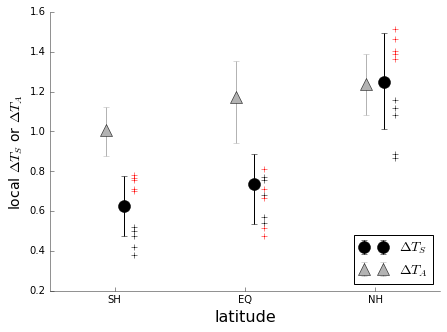

In [29]:
figure(figsize=(7,5))
yerr1=np.average(dts,axis=1)-np.percentile(dts,5,axis=1)
yerr2=np.percentile(dts,95,axis=1)-np.average(dts,axis=1)
errorbar(np.arange(3)+0.07,np.average(dts,axis=1),yerr=[yerr1,yerr2],color='k',fmt='o',\
         markersize=12,label='$\Delta T_S$')

yerr1=np.average(dta,axis=1)-np.percentile(dta,5,axis=1)
yerr2=np.percentile(dta,95,axis=1)-np.average(dta,axis=1)
errorbar(np.arange(3)-0.07,np.average(dta,axis=1),yerr=[yerr1,yerr2],color='0.7',fmt='^',\
         markersize=12,label='$\Delta T_A$')

xlabel('latitude',fontsize=16);ylabel('local $\Delta T_S$ or $\Delta T_A$',fontsize=14)
xticks([0,1,2],'SH,EQ,NH'.split(','))
xlim(-0.5,2.5)

ind=np.where(lambda1 < np.percentile(lambda1,5))[0]
for ii in range(3):
    plot(np.zeros(len(ind))+ii+0.15,dts[ii,ind],'k+')
ind=np.where(lambda1 > np.percentile(lambda1,95))[0]
for ii in range(3):
    plot(np.zeros(len(ind))+ii+0.15,dts[ii,ind],'r+')

legend(loc=4,fontsize=14)
colorplotLeft(gca())

### calculate the source of $\lambda$ variability ...

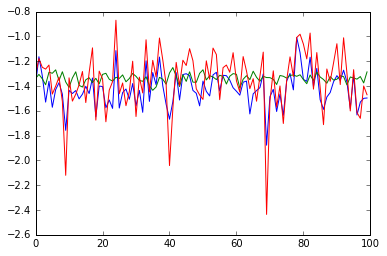

In [35]:
# lambda2 = lambda calculated with the average lambda; this evaluates the impact of different pattern
lambda2=np.average(np.average(ratioTs,axis=1).reshape(3,1)*dts,axis=0)/np.average(dts,axis=0)

# lambda3 = lambda calculated with average temperature change in each region; this evaluates the impact
# of different values of lambda in each region
lambda3=np.average(np.average(dts,axis=1).reshape(3,1)*ratioTs,axis=0)/np.average(dts,axis=0)

plot(lambda1);plot(lambda2);plot(lambda3)

As can clearly be seen, the major source of variability is the variability in $\lambda$ in each region

### calculate the source of $\Theta$ variability ...

(-2.5, -0.7)

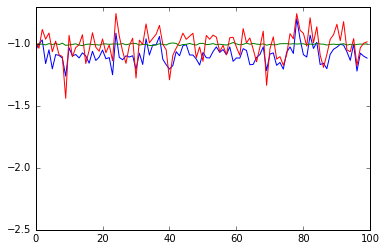

In [37]:
# theta2 = lambda calculated with the average lambda; this evaluates the impact of different pattern
theta2=np.average(np.average(ratioTa,axis=1).reshape(3,1)*dta,axis=0)/np.average(dta,axis=0)

# theta3 = lambda calculated with average temperature change in each region; this evaluates the impact
# of different values of lambda in each region
theta3=np.average(np.average(dta,axis=1).reshape(3,1)*ratioTa,axis=0)/np.average(dta,axis=0)

plot(theta1);plot(theta2);plot(theta3)
ylim(-2.5,-0.7)

As can clearly be seen, the major source of variability is the variability in $\Theta$ in each region

### other plots

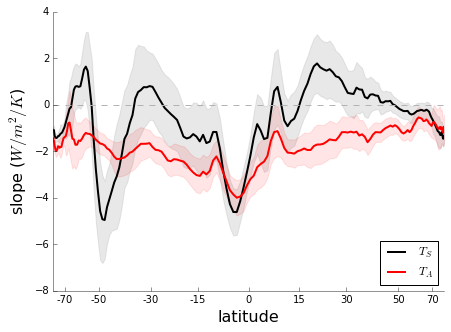

In [7]:
figure(figsize=(7,5))

# get zonal average quantities for regression vs. Ts
ts1=np.average(ts.data,axis=3).squeeze();flux1=np.average(flux.data,axis=3).squeeze()

slope=[];err=[]
# loop through and calculate correlation coefficient at each latitude
for tt,ff in zip(ts1.T,flux1.T):
    tt1=detrend(tt);ff1=detrend(ff) # detrend the data first, though
    fit=ols.ols(ff1,tt1);fit.est_auto()
    slope.append(fit.b[1]);err.append(fit.conf90[1])

plot(np.sin(ts.lat/180.*np.pi),slope,'k',lw=2,label='$T_{S}$')
fill_between(np.sin(ts.lat/180.*np.pi),np.array(slope)+np.array(err),\
    np.array(slope)-np.array(err),color='0.7',alpha='0.3')

# get zonal average quantities for regression vs. Ta
ts1=np.average(t500.data,axis=3).squeeze();flux1=np.average(flux.data,axis=3).squeeze()

slope=[];err=[]
# loop through and calculate correlation coefficient at each latitude
for tt,ff in zip(ts1.T,flux1.T):
    tt1=detrend(tt);ff1=detrend(ff) # detrend the data first, though
    fit=ols.ols(ff1,tt1);fit.est_auto()
    slope.append(fit.b[1]);err.append(fit.conf90[1])
    
plot(np.sin(ts.lat/180.*np.pi),slope,'r',lw=2,label='$T_{A}$')
fill_between(np.sin(ts.lat/180.*np.pi),np.array(slope)+np.array(err),\
    np.array(slope)-np.array(err),color='r',alpha='0.1')

xlabel('latitude',fontsize=16);ylabel('slope ($W/m^2/K$)',fontsize=16)
xticks(np.sin(np.array([-70,-50,-30,-15,0,15,30,50,70])*3.14/180.), 
       '-70,-50,-30,-15,0,15,30,50,70'.split(','))
colorplotLeft(gca())
legend(loc=4)
axhline(0,ls='dashed',color='0.7')

# savefig('fig3.eps')

without detrending

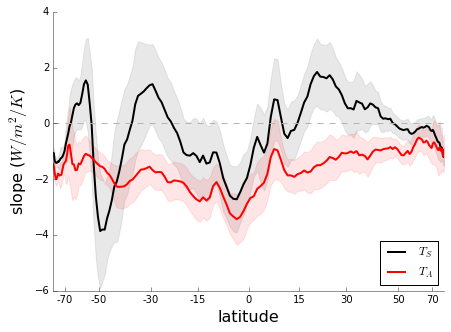

In [9]:
figure(figsize=(7,5))

# get zonal average quantities for regression vs. Ts
ts1=np.average(ts.data,axis=3).squeeze();flux1=np.average(flux.data,axis=3).squeeze()

slope=[];err=[]
# loop through and calculate correlation coefficient at each latitude
for tt,ff in zip(ts1.T,flux1.T):
#     tt1=detrend(tt);ff1=detrend(ff) # detrend the data first, though
    tt1=tt;ff1=ff
    fit=ols.ols(ff1,tt1);fit.est_auto()
    slope.append(fit.b[1]);err.append(fit.conf90[1])

plot(np.sin(ts.lat/180.*np.pi),slope,'k',lw=2,label='$T_{S}$')
fill_between(np.sin(ts.lat/180.*np.pi),np.array(slope)+np.array(err),\
    np.array(slope)-np.array(err),color='0.7',alpha='0.3')

# get zonal average quantities for regression vs. Ta
ts1=np.average(t500.data,axis=3).squeeze();flux1=np.average(flux.data,axis=3).squeeze()

slope=[];err=[]
# loop through and calculate correlation coefficient at each latitude
for tt,ff in zip(ts1.T,flux1.T):
#     tt1=detrend(tt);ff1=detrend(ff) # detrend the data first, though
    tt1=tt;ff1=ff
    fit=ols.ols(ff1,tt1);fit.est_auto()
    slope.append(fit.b[1]);err.append(fit.conf90[1])
    
plot(np.sin(ts.lat/180.*np.pi),slope,'r',lw=2,label='$T_{A}$')
fill_between(np.sin(ts.lat/180.*np.pi),np.array(slope)+np.array(err),\
    np.array(slope)-np.array(err),color='r',alpha='0.1')

xlabel('latitude',fontsize=16);ylabel('slope ($W/m^2/K$)',fontsize=16)
xticks(np.sin(np.array([-70,-50,-30,-15,0,15,30,50,70])*3.14/180.), 
       '-70,-50,-30,-15,0,15,30,50,70'.split(','))
colorplotLeft(gca())
legend(loc=4)
axhline(0,ls='dashed',color='0.7')

# savefig('fig3.eps')

## control run analysis

In [10]:
mod3=xr.open_dataset('historical/zonal/zonal0001.nc')

In [16]:
flux=mod3['srad0']+mod3['trad0']
flux=np.array(flux).squeeze()[:23940,] # TOA flux
ts=data.anomaly(np.array(mod3.temp2).squeeze())[:23940,];ta=data.anomaly(np.array(mod3.t).squeeze())[:23940,]

In [17]:
def redim(xx):
    """reshape array so that we can do the slope calculation"""
    output=[]
    for x1 in xx:
        # reshape into 15-year segments (180 months)
        x2=x1.reshape(133,180,96)
        
        # calculate anomalies of each 15-year segment
        x3=np.average(x2.reshape(133,15,12,96),axis=1)
        x4=x2-x3[:,np.arange(180) % 12,:]
        
        output.append(x4)
    return output

f1,ts1,ta1=redim([flux,ts,ta])

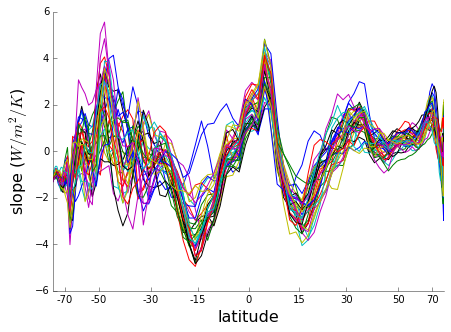

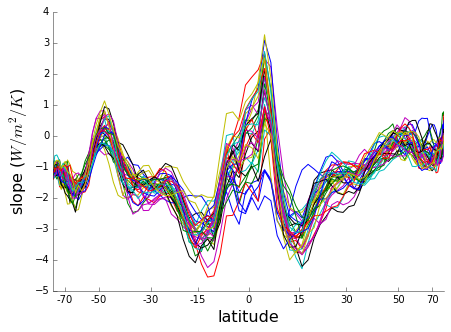

In [91]:
for tx in [ts1,ta1]:
    slope=np.average(f1*tx,axis=1)/np.std(tx,axis=1)**2

    figure(figsize=(7,5))
    for ii in slope:
        plot(np.sin(np.deg2rad(mod3.lat)),ii)

    xlabel('latitude',fontsize=16);ylabel('slope ($W/m^2/K$)',fontsize=16)
    xticks(np.sin(np.array([-70,-50,-30,-15,0,15,30,50,70])*3.14/180.), 
           '-70,-50,-30,-15,0,15,30,50,70'.split(','))
    colorplotLeft(gca())


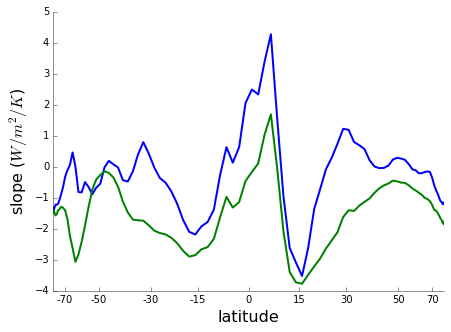

In [18]:
figure(figsize=(7,5))

for tx in [ts1,ta1]:
    slope=np.average(f1*tx,axis=1)/np.std(tx,axis=1)**2

    plot(np.sin(np.deg2rad(mod3.lat)),np.average(slope,axis=0),lw=2)

#     fill_between(np.sin(np.deg2rad(mod3.lat)),np.min(slope,axis=0),np.max(slope,axis=0),
#         color='0.7',alpha='0.3')

    xlabel('latitude',fontsize=16);ylabel('slope ($W/m^2/K$)',fontsize=16)
    xticks(np.sin(np.array([-70,-50,-30,-15,0,15,30,50,70])*3.14/180.), 
           '-70,-50,-30,-15,0,15,30,50,70'.split(','))
colorplotLeft(gca())


## historical run analysis

In [81]:
mod3=xr.open_dataset('historical/zonal/zonalEnsembleAvg.nc')
forcing=xr.open_dataset('historical/zonal/forcing_zonal.nc')

In [82]:
mod3['time']=pd.to_datetime(mod3.time, format='%Y%m%d.%f')
mod3=mod3.groupby('time.year').mean(dim='time') # annual average

# display mod3 variable
mod3

<xarray.Dataset>
Dimensions:  (lat: 96, lev: 1, lon: 1, year: 156)
Coordinates:
  * lon      (lon) float64 0.0
  * lat      (lat) float64 88.57 86.72 84.86 83.0 81.13 79.27 77.41 75.54 ...
  * lev      (lev) float64 5e+04
  * year     (year) int64 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 ...
Data variables:
    flux     (year, lat, lon) float64 -127.1 -127.2 -127.0 -126.0 -124.8 ...
    temp2    (year, lat, lon) float32 256.43 256.486 256.507 256.499 256.614 ...
    t        (year, lev, lat, lon) float32 237.807 237.879 238.02 238.236 ...

In [57]:
check forcing.f

------> check(forcing.f)
type:  <class 'xarray.core.dataarray.DataArray'>
shape:  (159, 96, 1)
min/max:  -5.11976099014   4.83820724487


In [83]:
# calculate net flux including forcing
forcing['flux']=forcing.srad0+forcing.trad0
flux=np.array(mod3.flux)-np.array(forcing.f[:156,])

# estimate change from first decade to last
dflux=(flux[-10:]-flux[:10]).squeeze()
dts=(np.array(mod3.temp2[-10:])-np.array(mod3.temp2[:10])).squeeze()
dta=(np.array(mod3.t[-10:])-np.array(mod3.t[:10])).squeeze()

ratioTs=np.average(dflux,axis=0)/np.average(dts,axis=0)
ratioTa=np.average(dflux,axis=0)/np.average(dta,axis=0)

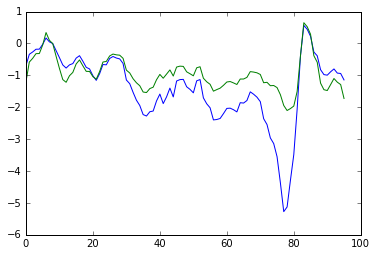

In [80]:
plot(ratioTs);plot(ratioTa)

# look at individual ensemble members

In [81]:
mod3=xr.open_dataset('historical/zonal/zonalEnsemble.nc')
forcing=xr.open_dataset('historical/zonal/forcing_zonal.nc')

In [82]:
mod3['time']=pd.to_datetime(mod3.time, format='%Y%m%d.%f')
mod3=mod3.groupby('time.year').mean(dim='time') # annual average

# display mod3 variable
mod3

<xarray.Dataset>
Dimensions:  (lat: 96, lev: 100, lon: 1, sfc: 100, year: 156)
Coordinates:
  * lon      (lon) float64 0.0
  * lat      (lat) float64 88.57 86.72 84.86 83.0 81.13 79.27 77.41 75.54 ...
  * sfc      (sfc) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  * lev      (lev) float64 5e+04 5e+04 5e+04 5e+04 5e+04 5e+04 5e+04 5e+04 ...
  * year     (year) int64 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 ...
Data variables:
    flux     (year, sfc, lat, lon) float64 -125.3 -125.7 -125.7 -124.7 ...
    temp2    (year, sfc, lat, lon) float32 256.393 256.598 256.689 256.566 ...
    t        (year, lev, lat, lon) float32 237.726 237.779 237.919 238.144 ...

In [100]:
forcing

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 1, time: 159)
Coordinates:
  * lon        (lon) float64 0.0
  * lat        (lat) float64 88.57 86.72 84.86 83.0 81.13 79.27 77.41 75.54 ...
  * time       (time) float64 1.85e+07 1.851e+07 1.852e+07 1.853e+07 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 1.85e+07 1.85e+07 1.851e+07 1.851e+07 ...
    f          (time, lat, lon) float64 2.321 0.703 0.783 1.396 0.2535 ...
    srad0      (time, lat, lon) float32 2.09736 0.474405 0.547247 1.40507 ...
    trad0      (time, lat, lon) float32 0.223324 0.228607 0.235753 ...
    flux       (time, lat, lon) float32 2.32069 0.703012 0.783 1.39647 ...
Attributes:
    CDI:          Climate Data Interface version 1.7.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Thu Jun 15 21:08:06 2017: cdo zonmean forcing_global.nc for...
    institution:  MPIMET
    CDO:          Climate Data Operators version 1.7.2 (http://mpimet.mpg.de/

In [84]:
# calculate net flux including forcing
forcing['flux']=forcing.srad0+forcing.trad0
flux=np.array(mod3.flux)-np.array(forcing.f[:156,]).reshape(156,1,96,1)

# estimate change from first decade to last
dflux=(flux[-10:]-flux[:10]).squeeze()
dts=(np.array(mod3.temp2[-10:])-np.array(mod3.temp2[:10])).squeeze()
dta=(np.array(mod3.t[-10:])-np.array(mod3.t[:10])).squeeze()

ratioTs=np.average(dflux,axis=0)/np.average(dts,axis=0)
ratioTa=np.average(dflux,axis=0)/np.average(dta,axis=0)

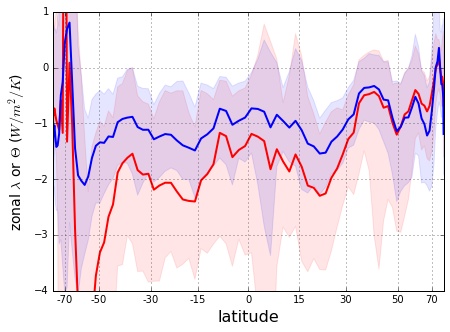

In [99]:
figure(figsize=(7,5))
for nn,tx in enumerate([ratioTs,ratioTa]):
    
    plot(np.sin(np.deg2rad(mod3.lat)),np.average(tx,axis=0),'r,b'.split(',')[nn],lw=2)
    fill_between(np.sin(mod3.lat/180.*np.pi),np.min(tx,axis=0),\
        np.max(tx,axis=0),color='r,b'.split(',')[nn],alpha='0.1')

    ylim(-4,1)
    xlabel('latitude',fontsize=16);ylabel('zonal $\lambda$ or $\Theta$ ($W/m^2/K$)',fontsize=14)
    xticks(np.sin(np.array([-70,-50,-30,-15,0,15,30,50,70])*3.14/180.), 
        '-70,-50,-30,-15,0,15,30,50,70'.split(','))
grid()

2D plot

In [40]:
def corr2d2d(d1,d2):
    """calculate correlation between individual grid points: d1[x,y] & d2[x,y]"""
    corr=np.average(d1.data*d2.data,axis=0).squeeze()
    denom=(np.std(d1.data,axis=0)*np.std(d2.data,axis=0)).squeeze()

    r=corr/denom # correlation coefficient
    return r

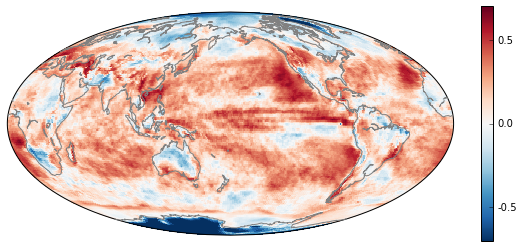

In [42]:
r=corr2d2d(ts,flux) # correlation coefficient

fig=figure(figsize=(10,6))
m=Basemap(projection='moll', resolution='c',lon_0=180) 
m.drawcoastlines(color='0.5',ax=gca()) # draw coastlines
x1,y1=m(*np.meshgrid(ts.lon,ts.lat))
im1=m.pcolormesh(x1,y1,r,cmap=plt.cm.RdBu_r,vmin=-0.7,vmax=0.7,ax=gca())
colorbar(im1,ax=gca(),shrink=0.7,format='%.1f', ticks=[-1,-0.5,0,0.5,1])

# savefig('figS2.eps')

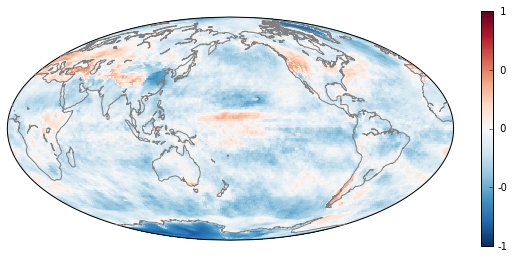

In [32]:
corr=np.average(t500.data*flux.data,axis=0).squeeze()
denom=(np.std(t500.data,axis=0)*np.std(flux.data,axis=0)).squeeze()

r=corr/denom # correlation coefficient

fig=figure(figsize=(10,6))
m=Basemap(projection='moll', resolution='c',lon_0=180) 
m.drawcoastlines(color='0.5',ax=gca()) # draw coastlines
x1,y1=m(*np.meshgrid(t500.lon,t500.lat))
im1=m.pcolormesh(x1,y1,r,cmap=plt.cm.RdBu_r,vmin=-1,vmax=1,ax=gca())
colorbar(im1,ax=gca(),shrink=0.7,format='% 2.0f', ticks=[-1,-0.5,0,0.5,1])

# savefig('figS2.eps')

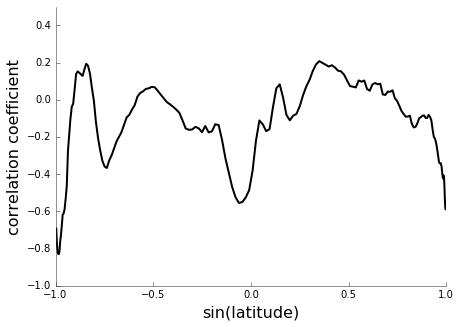

In [7]:
# get zonal average quantities
ts1=np.average(ts.data,axis=3).squeeze();flux1=np.average(flux.data,axis=3).squeeze()

corr=[]
# loop through and calculate correlation coefficient at each latitude
for tt,ff in zip(ts1.T,flux1.T):
    tt1=detrend(tt);ff1=detrend(ff) # detrend the data first, though
    corr.append(stats.linregress(tt1,ff1).rvalue)
    
figure(figsize=(7,5));plot(np.sin(ts.lat/180.*np.pi),corr,'k',lw=2,label='$T_S$')

# cov=np.average(np.average(t500.data,axis=3)*np.average(flux.data,axis=3),axis=0).squeeze()/\
# 	np.std(np.average(t500.data,axis=3).squeeze(),axis=0)/np.std(np.average(flux.data,axis=3).squeeze(),axis=0)
# plot(np.sin(ts.lat/180.*np.pi),cov,'0.7',label='$T_{500}$')
ylim(-1,0.5)
xlabel('sin(latitude)',fontsize=16);ylabel('correlation coefficient',fontsize=16)
colorplotLeft(gca())

# savefig('figS2.eps')

In [46]:
## Read in models
modout=xr.open_dataset('historical/globalavg/historicalEnsemble.nc')
modout['time']=pd.to_datetime(modout.time, format='%Y%m%d.%f')
modout=modout.groupby('time.year').mean(dim='time') # annual average

flux=np.array(modout.srad0+modout.trad0).squeeze()
ts=np.array(modout.temp2).squeeze()
ta=np.array(modout.t_trop).squeeze()
tag=np.array(modout.t).squeeze()
tst=np.array(modout.temp2_trop).squeeze()

In [47]:
## forcing_aed_ensemble described in notes on 170426
# forcing is already annually averaged
forcing=xr.open_dataset('historical/globalavg/forcing_aed_ensemble.nc')
forcing=np.array(forcing.f).squeeze()
forcing=forcing[:156];forcing=forcing.reshape(156,1) # make same length as model runs

print 'delta F = {:.2f} W/m^2'.format(np.average(forcing[-10:]-forcing[:10]))

delta F = 2.20 W/m^2


In [48]:
## calculate lambda and theta
## output is m1all; m1all[0] is lambda, while m1all[1] is theta
s=len(forcing)

## analyze
length=10 # length of period (in years) at beginning and end to average
m1all=[]
for tempx in [ts,ta,tag,tst]:

    flux1=flux-forcing 
    
    drg=np.average(flux1[-length:,]-flux1[:length,],axis=0)
    dtg=np.average(tempx[-length:,]-tempx[:length,],axis=0)

    m1all.append(drg/dtg)